# Predictive maintenance

A fleet of machines is transmitting daily aggregated telemetry data. 
Aa sample dataset with machine events statistics is partitioned by day and contains the machine serial number, a boolean that indicates if the machine breaks (event=1) on that specific day or not (event=0) and (9) features that characterize the machine.

## 1. Overview

Using the given dataset, I will build and tune the LSTM model that will try to predict which machine breaks down - "1-event". 
I will follow the ML way:
- analyze the given dataset to understand its complexity and if possible reduce its complexity 
- analyze event distribution and its correlation to features in order to chose best feature set for the given task 
- do necessairy Feature Engineering based on analyzes
- prepare training and dataset
- build the LSTM model
- define training parameters and performance measures. My goal would be to minimize false positives and false negatives 
- train/tune model(s)
- evaluate model(s)

## 2. Import Libraries and Load Data


I will import python libraries which I will need for this task. 

### 2.1 Libraries

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import h5py
import os


from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation



## 3. Exploring Data 

The only file containing dataset is machine_breakdown.csv. I will read it as panda's Data Frame, sort and plot first and last 5 rows

In [2]:
df = pd.read_csv('machine_breakdown.csv')

In [3]:
df = df.sort_values(by=['machine','date'])

In [4]:
df

,date,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9
0,2015-01-01,S1F01085,0,0,7,407438,215630672,6,0,52,56,0.0
1163,2015-01-02,S1F01085,0,0,7,407438,1650864,6,0,52,56,0.0
2326,2015-01-03,S1F01085,0,0,7,407438,124017368,6,0,52,56,0.0
3489,2015-01-04,S1F01085,0,0,7,407439,128073224,6,0,52,56,0.0
4651,2015-01-05,S1F01085,0,0,7,408114,97393448,6,0,52,56,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
65334,2015-04-02,Z1F2PBHX,0,0,0,162645,180917784,5,0,0,0,0.0
65819,2015-04-03,Z1F2PBHX,0,0,0,162645,33952520,5,0,0,0,0.0
66304,2015-04-04,Z1F2PBHX,0,0,0,162645,59053184,5,0,0,0,0.0
66789,2015-04-05,Z1F2PBHX,0,0,0,163047,110545440,5,0,0,0,0.0


There are 12 columns. First column (data) is our date stamp followed by machine, which is defining the SN of the machine. Third is event - our outcome defined as 0 - for no event and 1 - for event occured. Last 9 columns represent telemetry data of 9 sensors deliver daily. One row of data per one observed machine daily

Do we have missing data in the dataset? Co called "nands" need to be localized and "neutralized" to prevent errors

In [5]:
# Are there missing values in  dataset?
df.isnull().sum()

date        0
machine     0
event       0
feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
feature7    0
feature8    0
feature9    0
dtype: int64

There are no missing values in the dataset! Now let us check how many unique machines do we observe and how many 1-events vs 0-events are there in the dataset

In [6]:
# How many unique machines are there in the dataset?
len(df['machine'].unique())

1168

In [7]:
# How many 0-events are there in the dataset. We may think about them as machine is "working normally" - no failures"
# How many 1-events are here in the dataset. This event we may describe as machine failure
df['event'].value_counts()

0    124388
1       106
Name: event, dtype: int64

There are less than 0.1% of 1-events. Dataset is extreemly imbalanced.

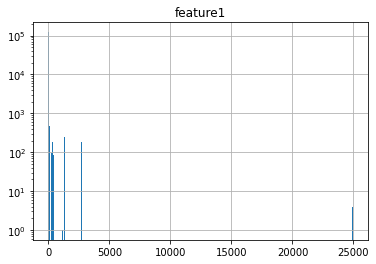

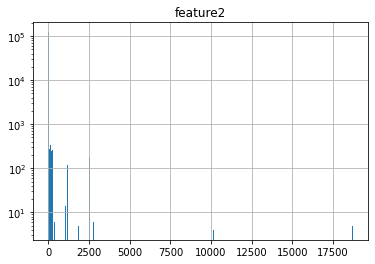

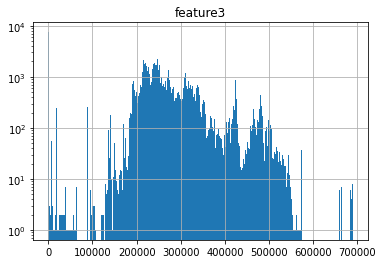

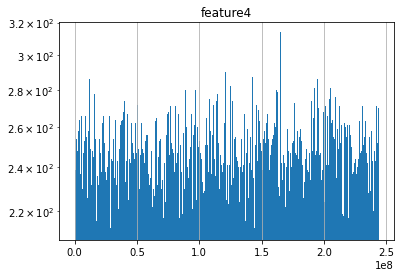

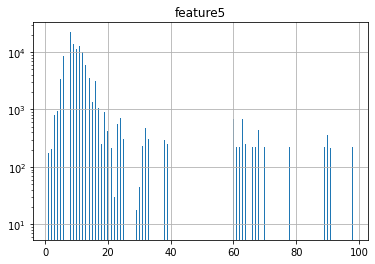

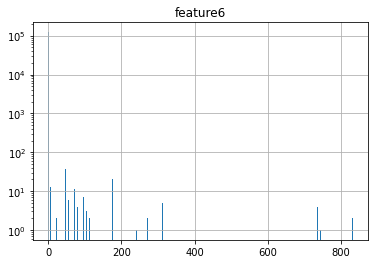

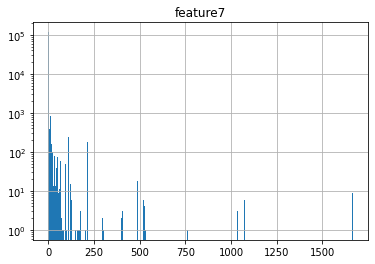

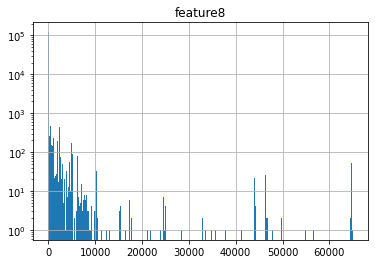

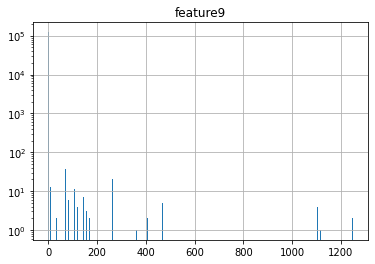

In [8]:
#Plotting the histograms of Features
for name in ['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8','feature9']:
    df.hist(column=[name], log=True, bins=500)

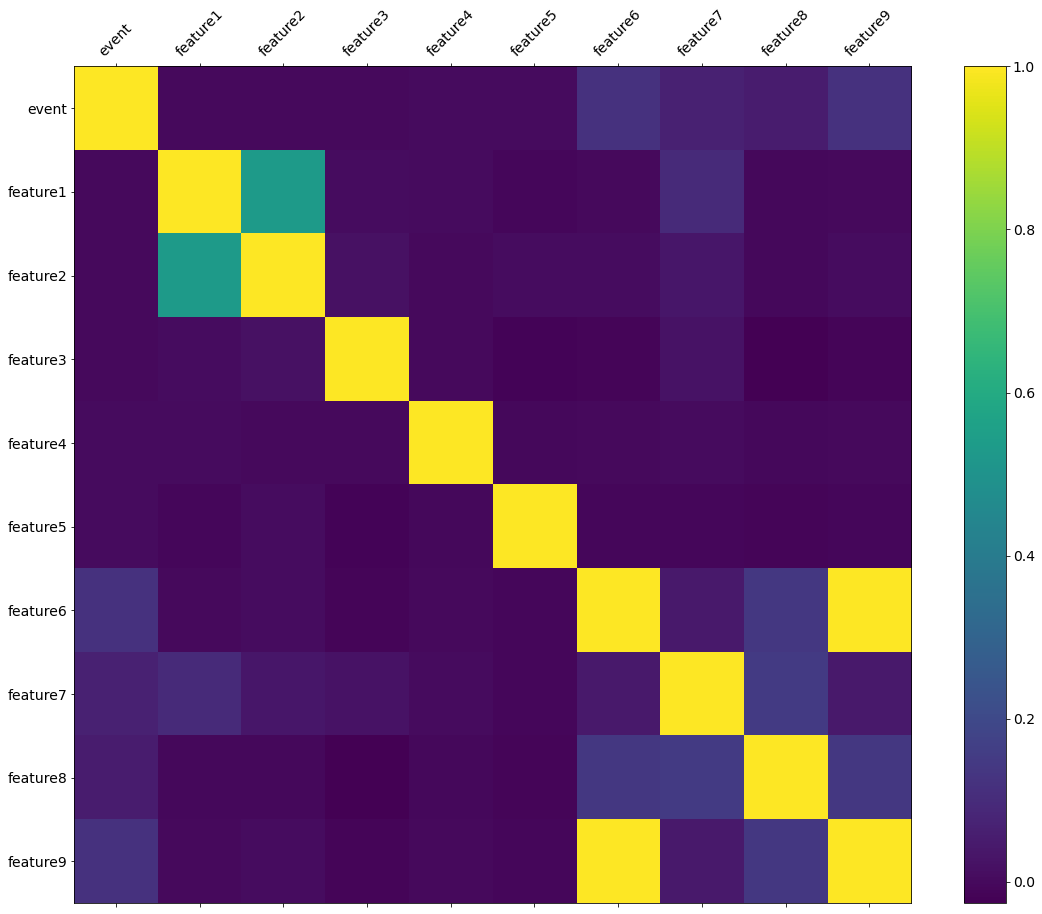

In [9]:
#Plotting the correlation matrix of features and event
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Feature 6 and Feature 9 are 100% correlated. We can later delete Feature 9

## 4. Data processing

To prepare the data I had to calculate the RUL column (Rest Useful Life) indicating the number of days before the event=1. I will also delete machines which reported for less than 10 days, what is too short to have a valuable observation.

In [10]:
short = 10 # how short can be the sequence of consecutive reporting days of the machine
RUL_noFailure = 365 # value for RUL when no failure were registered

In [11]:
df_max_date = df.groupby('machine').agg({'date':max})
df_min_date = df.groupby('machine').agg({'date':min})

In [12]:
df_short = df['machine'].value_counts();

In [13]:
for ma in df_short.index:
    df_short.drop(df_short[df_short > short].index, inplace = True)

In [14]:
for ma in df_short.index:
    df.drop(df[df['machine'] == ma].index,inplace=True)

In [15]:
df_event1 = df.loc[df['event'] == 1]


In [16]:
df['max_date']=df.machine.map(df_max_date.date.to_dict())

In [17]:
df['min_date']=df.machine.map(df_min_date.date.to_dict())

In [18]:
df.date = pd.to_datetime(df.date)

In [19]:
df.max_date = pd.to_datetime(df.max_date)

In [20]:
df.min_date = pd.to_datetime(df.min_date)
df['RUL'] = RUL_noFailure

In [21]:
for ma in df_event1.machine:
    df.loc[df['machine'] == ma, 'RUL'] = (df['max_date'] - df['date']).dt.days.astype('int16')
    

In [22]:
df['cycle'] = (df['date'] - df['min_date'])
df['cycle'] = df['cycle'].dt.days.astype('int16') +1

In [23]:
df.drop(['date','max_date', 'min_date', 'feature9'],axis=1,inplace=True)

In [24]:
# lets split : about 30% for testing, 70% for training
train_df  = df.iloc[:80000:,:]
test_df = df.iloc[80000:,:]

In [25]:
train_df.reset_index(drop =True)

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,RUL,cycle
0,S1F01E6Y,0,0,0,237394,173295968,12,0,0,0,365,1
1,S1F01E6Y,0,0,0,238718,192723440,12,0,0,0,365,2
2,S1F01E6Y,0,0,0,240021,214317232,12,0,0,0,365,3
3,S1F01E6Y,0,0,0,241264,236917296,12,0,0,0,365,4
4,S1F01E6Y,0,0,0,242553,17099072,12,0,0,0,365,5
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,W1F14XGD,0,0,0,221503,106768928,12,0,0,832,155,54
79996,W1F14XGD,0,0,0,221503,23045808,12,0,0,840,154,55
79997,W1F14XGD,0,0,0,221514,50799416,12,0,0,840,153,56
79998,W1F14XGD,0,0,0,221517,77740616,12,0,0,840,152,57


In [26]:
test_df.reset_index(drop =True)

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,RUL,cycle
0,W1F14XGD,0,0,0,222388,2704160,12,0,0,840,150,59
1,W1F14XGD,0,0,0,223775,19080432,12,0,0,936,149,60
2,W1F14XGD,0,0,0,224204,223354528,12,0,0,944,148,61
3,W1F14XGD,0,0,0,224204,133256160,12,0,0,944,147,62
4,W1F14XGD,0,0,0,224204,82986800,12,0,0,944,146,63
...,...,...,...,...,...,...,...,...,...,...,...,...
42354,Z1F2PBHX,0,0,0,162645,180917784,5,0,0,0,365,92
42355,Z1F2PBHX,0,0,0,162645,33952520,5,0,0,0,365,93
42356,Z1F2PBHX,0,0,0,162645,59053184,5,0,0,0,365,94
42357,Z1F2PBHX,0,0,0,163047,110545440,5,0,0,0,365,95


## 5. Features

In [27]:
# MinMax normalization
from sklearn.preprocessing import MinMaxScaler
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['machine','cycle','RUL', 'event'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

C:\Users\xyz\AppData\Local\Temp/ipykernel_23364/1536191356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cycle_norm'] = train_df['cycle']


,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,RUL,cycle,cycle_norm
2,S1F01E6Y,0,0.0,0.0,0.413122,0.709821,0.104167,0.0,0.0,0.0,365,1,0.000000
1165,S1F01E6Y,0,0.0,0.0,0.415426,0.789396,0.104167,0.0,0.0,0.0,365,2,0.003279
2328,S1F01E6Y,0,0.0,0.0,0.417694,0.877844,0.104167,0.0,0.0,0.0,365,3,0.006557
3491,S1F01E6Y,0,0.0,0.0,0.419857,0.970414,0.104167,0.0,0.0,0.0,365,4,0.009836
4653,S1F01E6Y,0,0.0,0.0,0.422101,0.070038,0.104167,0.0,0.0,0.0,365,5,0.013115


In [28]:
test_df['cycle_norm'] = test_df['cycle']
cols_normalize = test_df.columns.difference(['machine','cycle','RUL', 'event'])
min_max_scaler = MinMaxScaler()
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(test_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=test_df.index)
join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = join_df.reindex(columns = test_df.columns)
test_df.head()

C:\Users\brm738\AppData\Local\Temp/ipykernel_23364/2108282481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cycle_norm'] = test_df['cycle']


,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,RUL,cycle,cycle_norm
44309,W1F14XGD,0,0.0,0.0,0.403353,0.011077,0.117021,0.0,0.0,0.012929,150,59,0.190164
44981,W1F14XGD,0,0.0,0.0,0.405868,0.078156,0.117021,0.0,0.0,0.014407,149,60,0.193443
45653,W1F14XGD,0,0.0,0.0,0.406646,0.914890,0.117021,0.0,0.0,0.014530,148,61,0.196721
46325,W1F14XGD,0,0.0,0.0,0.406646,0.545835,0.117021,0.0,0.0,0.014530,147,62,0.200000
46997,W1F14XGD,0,0.0,0.0,0.406646,0.339925,0.117021,0.0,0.0,0.014530,146,63,0.203279


In [29]:
# generate label columns for training data.
# w1 = how many days before the event we will set the label to 1
w1 = 5
# Label1 indicates a failure will occur within the next 5 days.
# 1 indicates failure, 0 indicates healthy 
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df.head()

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,RUL,cycle,cycle_norm,label1
2,S1F01E6Y,0,0.0,0.0,0.413122,0.709821,0.104167,0.0,0.0,0.0,365,1,0.000000,0
1165,S1F01E6Y,0,0.0,0.0,0.415426,0.789396,0.104167,0.0,0.0,0.0,365,2,0.003279,0
2328,S1F01E6Y,0,0.0,0.0,0.417694,0.877844,0.104167,0.0,0.0,0.0,365,3,0.006557,0
3491,S1F01E6Y,0,0.0,0.0,0.419857,0.970414,0.104167,0.0,0.0,0.0,365,4,0.009836,0
4653,S1F01E6Y,0,0.0,0.0,0.422101,0.070038,0.104167,0.0,0.0,0.0,365,5,0.013115,0


In [30]:
# generate label1 column using the same w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,machine,event,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,RUL,cycle,cycle_norm,label1
44309,W1F14XGD,0,0.0,0.0,0.403353,0.011077,0.117021,0.0,0.0,0.012929,150,59,0.190164,0
44981,W1F14XGD,0,0.0,0.0,0.405868,0.078156,0.117021,0.0,0.0,0.014407,149,60,0.193443,0
45653,W1F14XGD,0,0.0,0.0,0.406646,0.914890,0.117021,0.0,0.0,0.014530,148,61,0.196721,0
46325,W1F14XGD,0,0.0,0.0,0.406646,0.545835,0.117021,0.0,0.0,0.014530,147,62,0.200000,0
46997,W1F14XGD,0,0.0,0.0,0.406646,0.339925,0.117021,0.0,0.0,0.014530,146,63,0.203279,0


In [31]:
# pick an observation sliding window size of 10 days - longer not possible. I already deleted machines which worked shorter than 10 days
sequence_length = 10

In [32]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length should be considered. I deleted machines with shorter observation time. """
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [33]:
# pick the feature columns 
sequence_cols = ['cycle_norm']
key_cols = ['machine', 'cycle']
label_cols = ['label1']


input_features = test_df.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]

# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

print(sequence_cols)

['cycle_norm', 'event', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'RUL']


In [34]:
# generator for the sequences

seq_gen = (list(gen_sequence(train_df[train_df['machine']==id], sequence_length, sequence_cols)) 
           for id in train_df['machine'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(74340, 10, 11)

In [35]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [36]:
# generate labels
label_gen = [gen_labels(train_df[train_df['machine']==id], sequence_length, ['label1']) 
             for id in train_df['machine'].unique()]
#label_gen = [gen_labels(train_df[train_df['machine']==id], sequence_length, ['event']) 
#             for id in train_df['machine'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(74340, 1)

## 6. Model

In [37]:
# build the network
# Feature weights
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# LSTM model
model = Sequential()

# The first layer
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# The second layer
model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# Dense sigmoid layer
model.add(Dense(units=nb_out, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           44800     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 75,051
Trainable params: 75,051
Non-trainable params: 0
_________________________________________________________________
None


## 7. Training

In [38]:
%%time
# fit the network
model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=20,   # We'll stop after 10 epochs
          batch_size=200, # 
          validation_split=0.20, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=2,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]) 

Epoch 1/20
298/298 [==============================] - 9s 17ms/step - loss: 0.0203 - accuracy: 0.9926 - val_loss: 0.0039 - val_accuracy: 0.9985
Epoch 2/20
298/298 [==============================] - 6s 19ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9999
Epoch 3/20
298/298 [==============================] - 5s 16ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0018 - val_accuracy: 0.9998
Epoch 4/20
298/298 [==============================] - 5s 16ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 5/20
298/298 [==============================] - 5s 16ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 6/20
298/298 [==============================] - 5s 16ms/step - loss: 9.0943e-04 - accuracy: 0.9998 - val_loss: 6.8645e-04 - val_accuracy: 0.9999
Epoch 7/20
298/298 [==============================] - 5s 17ms/step - loss: 6.6259e-04 - accuracy: 0.9999 - val_loss: 0.0018 - val_accu

In [39]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))



372/372 [==============================] - 2s 6ms/step - loss: 1.7422e-04 - accuracy: 1.0000
Training Accurracy: 0.9999731183052063


In [40]:
# make predictions and compute confusion matrix

y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")

y_true = label_array

print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

372/372 [==============================] - 2s 4ms/step
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[73948,     0],
       [    2,   390]], dtype=int64)

In [41]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'Training Precision: ', precision, '\n', 'Training Recall: ', recall, '\n', 'Training F1 Score:', f1)


Training Precision:  1.0 
 Training Recall:  0.9948979591836735 
 Training F1 Score: 0.9974424552429668


## 8. Testing and evaluation

In [42]:
seq_array_test_last = [test_df[test_df['machine']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['machine'].unique() if len(test_df[test_df['machine']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(238, 10, 11)

In [43]:
# y_mask is to filter out machinces where the sequence is bigger than the real observation time. 
y_mask = [len(test_df[test_df['machine']==id]) >= sequence_length for id in test_df['machine'].unique()]

label_array_test_last = test_df.groupby('machine')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(238, 10, 11)
(238, 1)


In [44]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Test Accurracy: {}'.format(scores_test[1]))


8/8 - 0s - loss: 3.0996e-05 - accuracy: 1.0000 - 56ms/epoch - 7ms/step
Test Accurracy: 1.0


In [45]:
# make predictions and compute confusion matrix
print(seq_array_test_last.shape)
#print('seq_array_test_last =', seq_array_test_last)
y_pred_test = (model.predict(seq_array_test_last,verbose=1, batch_size=200) > 0.5).astype("int32")
print('y_pred_test.shape: ', y_pred_test.shape)

y_true_test = label_array_test_last
print('y_true_test.shape: ', y_true_test.shape)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

(238, 10, 11)
2/2 [==============================] - 0s 6ms/step
y_pred_test.shape:  (238, 1)
y_true_test.shape:  (238, 1)
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[205   0]
 [  0  33]]


In [46]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)


Test Precision:  1.0 
 Test Recall:  1.0 
 Test F1 Score: 1.0


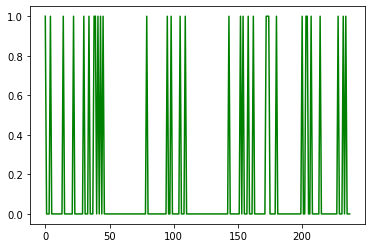

In [47]:
plt.plot(y_true_test, c='green')

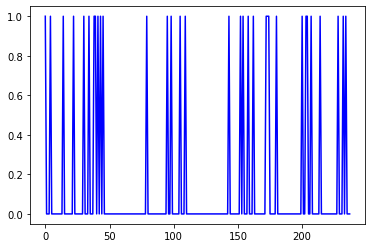

In [48]:
plt.plot(y_pred_test, c='blue')

## Thank you